__GRUPO 7:__

Beatriz Herguedas Pinedo

Pablo Hernández Aguado

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score

#### US Map Plotting

C:\Lenguajes\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
C:\Lenguajes\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


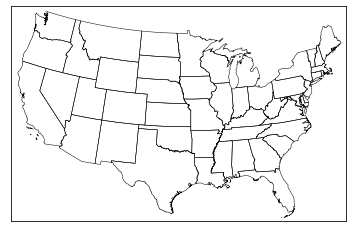

In [9]:
import os
os.environ['PROJ_LIB'] = r'C:\Lenguajes\Anaconda3\pkgs\proj-6.2.1-h9f7ef89_0\Library\share'

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

# create the map
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
map.readshapefile('st99_d00', name='states', drawbounds=True)

state_names = []
for shape_dict in map.states_info:
    state_names.append(shape_dict['NAME'])

# Práctica 1 · Parte 1: Clustering

## __Cuestión 1:__ Conjunto de datos.

#### Conjunto de datos.

In [187]:
arrestsDF = pd.read_csv("USArrests.csv", index_col=0)
arrestsDF = arrestsDF.rename_axis('State')
arrestsDF

,Murder,Assault,UrbanPop,Rape
State,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6
Colorado,7.9,204,78,38.7
Connecticut,3.3,110,77,11.1
Delaware,5.9,238,72,15.8
Florida,15.4,335,80,31.9


#### Descripción.

El conjunto de datos presenta, por cada 100.000 habitantes, el número de asaltos, asesinatos y violaciones por cada estado de los Estados Unidos. También contiene una variable que indica el porcentaje de población de ese estado que vive en áreas urbanas.

Con estos datos, podemos utilizar el método de Clustering para clasificar los distintos estados en grupos que presenten un perfil de arrestos similar.

#### Variables.

In [112]:
arrestsDF.dtypes

Murder      float64
Assault       int64
UrbanPop      int64
Rape        float64
dtype: object

#### Estadísticos descriptivos.

In [113]:
arrestsDesc = arrestsDF.describe()
arrestsDesc

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


In [114]:
# Tomamos los valores extremos de todas las variables en conjunto para el siguiente apartado.
plotMin = min(arrestsDesc.iloc[3])
plotMax = max(arrestsDesc.iloc[-1])

#### Conclusiones.

Claramente, hay diferencias generalizadas en la cantidad de arrestos por tipo de delito, siendo el asesinato el de menor cantidad y los asaltos los de mayor cantidad.

Por otro lado, nos encontramos con desviaciones típicas notables, que generan una dispersión mayor de los datos. En otro caso, este hecho nos sería bastante útil ante nuevos casos, pues por la dispersión, difícilmente este caso quedaría en término medio entre varios clusters. 

No obstante, puesto que los datos incluyen la mayoría de estados de EEUU, lo que buscamos es una nítida diferenciación entre clusters, para poder clasificar con precisión cada estado en su grupo correspondiente.

## __Cuestión 2:__ Re-escalado.

#### Argumentación a favor del re-escalado.

A continuación, mostramos el diagrama de dispersión de los pares de variables, con escala 1:1. Esto nos permite ver como los valores de la variable _Assault_ contribuyen de forma importante a dispersar los puntos a lo largo y ancho de las gráficas.

Por tanto, a pesar de que los valores de las variables _Murder_ y _Rape_ estén menos distanciadas entre sí, será necesario normalizar los valores antes de intentar agruparlos en clusters.

[]

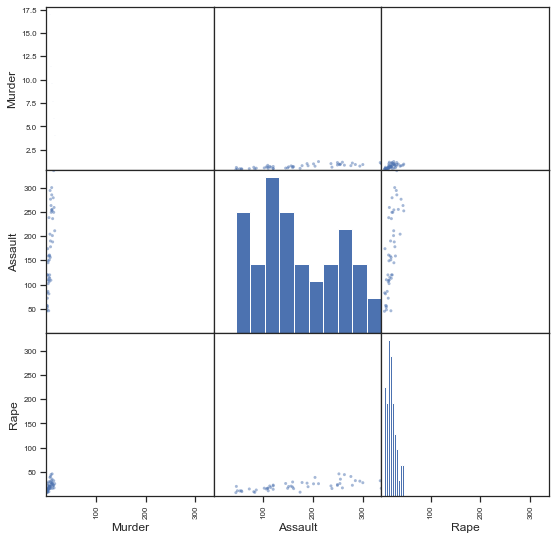

In [115]:
sM = pd.plotting.scatter_matrix( 
    arrestsDF.loc[:, ['Murder', 'Assault', 'Rape']], 
    figsize = (9,9), 
    diagonal = 'hist')

for i in range(3):
    for j in range(3):
        sM[i,j].set_xlim(plotMin,plotMax)
        if i != j:
             sM[i,j].set_ylim(plotMin,plotMax)
plt.plot()

_Aquí vemos el diagrama de dispersión con las escalas adaptadas por defecto a los valores comparados._

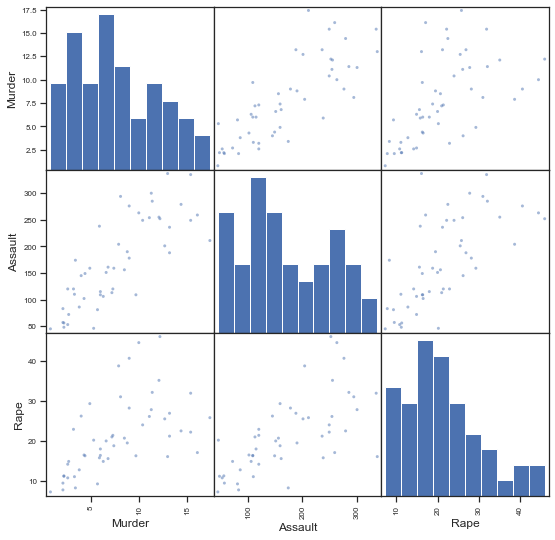

In [116]:
sM = pd.plotting.scatter_matrix( 
    arrestsDF.loc[:, ['Murder', 'Assault', 'Rape']], 
    figsize = (9,9), 
    diagonal = 'hist')

#### Aplicación del re-escalado.

In [117]:
scaler = StandardScaler()
scaler.fit(arrestsDF)

scaledData = scaler.transform(arrestsDF)
scaledDF = pd.DataFrame(data = scaledData, index = arrestsDF.index, columns = arrestsDF.columns)
scaledDF.head(10)

,Murder,Assault,UrbanPop,Rape
State,,,,
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814
Colorado,0.025976,0.402909,0.869548,1.883901
Connecticut,-1.040880,-0.736484,0.799761,-1.092723
Delaware,-0.437875,0.815030,0.450825,-0.585834
Florida,1.765415,1.990786,1.009122,1.150530


## __Cuestión 3:__ Clustering con K-Means.

#### Función de plotting en 3 dimensiones.

In [118]:
def plot_clusters(X, labels=None, centers=None, axis = None):
    colors = ['r','g','b','c','y','k','w','m',]
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection = '3d')
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    ax.scatter(X[:,0], X[:,1], X[:,2], c = labels, cmap = ListedColormap(colors))
    
    # Pintar los centroides de los clusters
    if centers is not None:
        ax.scatter(centers[:,0], centers[:,1], centers[:,2], marker = "x", color = 'k', s = 150, linewidths = 5, zorder=10)
        
    if axis is not None:
        ax.set_xlabel(axis[0])
        ax.set_ylabel(axis[1])
        ax.set_zlabel(axis[2])
        
    plt.show()

#### Búsqueda del número óptimo de clusters.

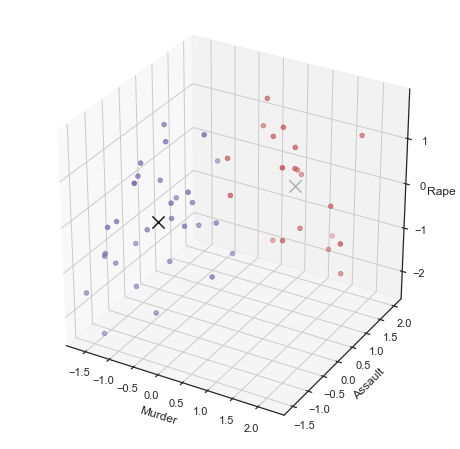

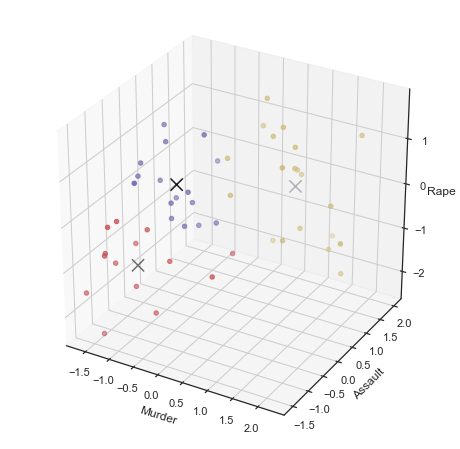

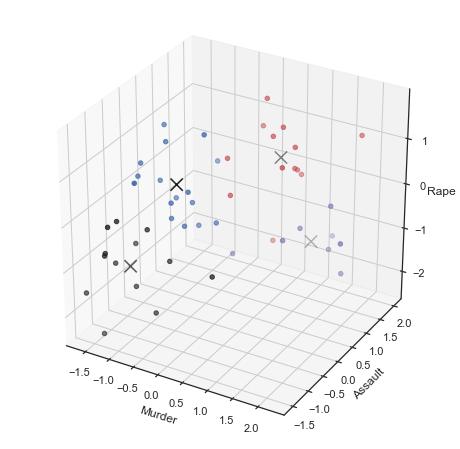

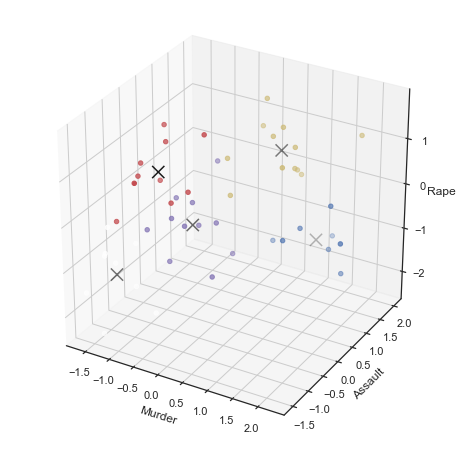

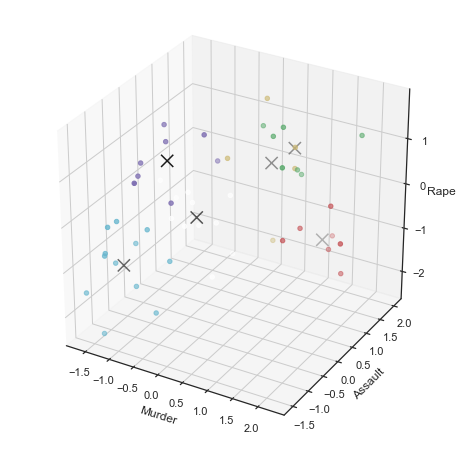

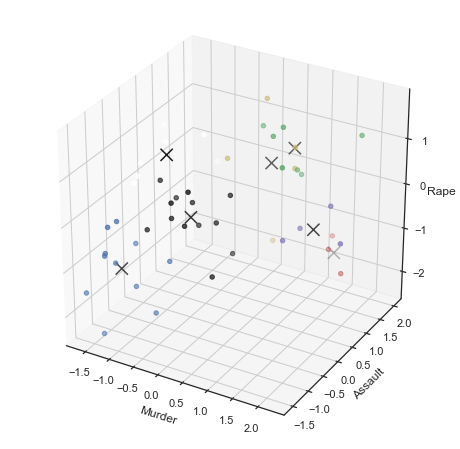

In [119]:
K_MAX = 8
davies_boulding = np.zeros(K_MAX-2)
for k in range(2, K_MAX): 
    km = KMeans(init = 'random', n_clusters = k, random_state = 333)
    km.fit(scaledDF)
    plot_clusters(scaledDF.values, km.labels_, km.cluster_centers_, ['Murder', 'Assault', 'Rape'])
    
    davies_boulding[k-2] = davies_bouldin_score(scaledDF.values, km.labels_) 

#### Índice de Davies-Bouldin.

Text(0.5, 1.0, 'Valor de Davies Boulding para diferentes k')

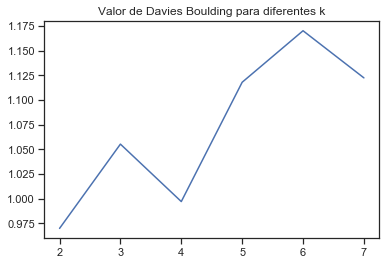

In [120]:
plt.plot(range(2, K_MAX), davies_boulding)
plt.title('Valor de Davies Boulding para diferentes k')

#### Conclusiones.

Por la gráfica de valores de Davies-Bouldin para los distintos valores de 'k', es trivial que el valor más acertado para agrupar nuestros datos es _k=2_ , es decir, 2 clusters; seguido de cerca por _k=3_ , con un valor ligeramente superior, por lo que sería interesante comprobar la división para este valor también.

## __Cuestión 4:__ Descripción de clusters.

### k = 2

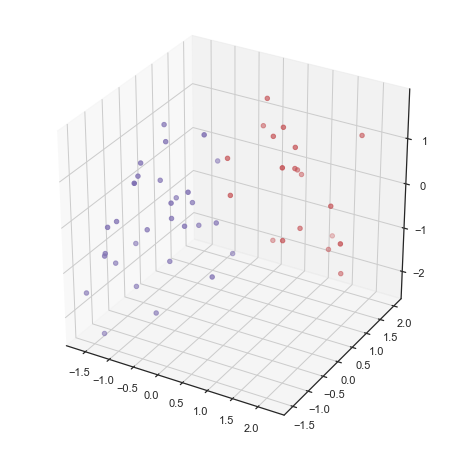

In [136]:
km2 = KMeans(init = 'random', n_clusters = 2, random_state = 333)
km2.fit(scaledDF)

# No graficamos los centros, pues estos están normalizados.
plot_clusters(scaledDF.values, km2.labels_)

In [137]:
arrestsDF2 = arrestsDF.assign( cluster = pd.Series(data = km2.labels_, index = arrestsDF.index))
arrestsDF2.head(10)

,Murder,Assault,UrbanPop,Rape,cluster
State,,,,,
Alabama,13.2,236,58,21.2,0
Alaska,10.0,263,48,44.5,0
Arizona,8.1,294,80,31.0,0
Arkansas,8.8,190,50,19.5,1
California,9.0,276,91,40.6,0
Colorado,7.9,204,78,38.7,0
Connecticut,3.3,110,77,11.1,1
Delaware,5.9,238,72,15.8,1
Florida,15.4,335,80,31.9,0


#### Por asesinato.

In [138]:
arrestsDF2.loc[: ,['Murder','cluster']].groupby(['cluster']).describe()

Murder                                                    
         count    mean       std  min     25%    50%     75%   max
cluster                                                           
0         20.0  12.165  2.684904  7.9  10.300  12.15  13.500  17.4
1         30.0   4.870  2.304291  0.8   2.825   4.65   6.525   9.7

#### Por asalto.

In [124]:
arrestsDF2.loc[: ,['Assault','cluster']].groupby(['cluster']).describe()

Assault                                                          
          count        mean       std    min     25%    50%    75%    max
cluster                                                                  
0          20.0  255.250000  44.11692  178.0  229.75  254.5  280.5  337.0
1          30.0  114.433333  47.48189   45.0   81.50  111.5  150.5  238.0

#### Por violación.

In [125]:
arrestsDF2.loc[: ,['Rape','cluster']].groupby(['cluster']).describe()

Rape                                                        
        count       mean       std   min     25%    50%     75%   max
cluster                                                              
0        20.0  29.165000  8.386473  16.1  23.625  27.35  32.850  46.0
1        30.0  15.943333  5.460370   7.3  11.225  16.05  19.875  29.3

#### Por población urbana.

In [126]:
arrestsDF2.loc[: ,['UrbanPop','cluster']].groupby(['cluster']).describe()

UrbanPop                                                      
           count       mean        std   min    25%   50%    75%   max
cluster                                                               
0           20.0  68.400000  14.463748  44.0  58.75  70.0  80.00  91.0
1           30.0  63.633333  14.406616  32.0  53.25  65.5  72.75  89.0

#### Conclusiones.

En definitiva, observamos que esta división nos genera 2 clusters, identificables claramente por lo que podríamos llamar nivel de criminalidad, teniendo el cluster '0' un nivel inferior al cluster '1', como podemos observar en la diferencia en las medias por tipo de delito entre clusters.

In [127]:
arrestsDF2.loc[: ,['Murder', 'Assault', 'Rape','cluster']].groupby(['cluster']).mean()

,Murder,Assault,Rape
cluster,,,
0,12.165,255.250000,29.165000
1,4.870,114.433333,15.943333


In [139]:
arrestsDF2['Risk'] = 'NaN'
arrestsDF2.loc[ arrestsDF2['cluster'] == 0, 'Risk'] = 'High'
arrestsDF2.loc[ arrestsDF2['cluster'] == 1, 'Risk'] = 'Low'
arrestsDF2.loc[:, ['Risk']].sort_values(by = ['Risk', 'State'])

,Risk
State,
Alabama,High
Alaska,High
Arizona,High
California,High
Colorado,High
Florida,High
Georgia,High
Illinois,High
Louisiana,High


#### Diagrama de dispersiones.

In [140]:
arrestsDF2.head()

,Murder,Assault,UrbanPop,Rape,cluster,Risk
State,,,,,,
Alabama,13.2,236,58,21.2,0,High
Alaska,10.0,263,48,44.5,0,High
Arizona,8.1,294,80,31.0,0,High
Arkansas,8.8,190,50,19.5,1,Low
California,9.0,276,91,40.6,0,High


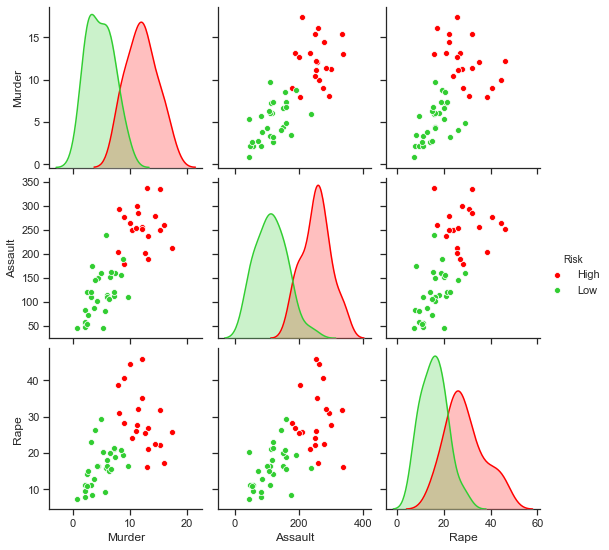

In [141]:
import seaborn as sns
sns.set(style = 'ticks')

sns.pairplot(
    arrestsDF2.iloc[:, [0,1,3,5]], 
    hue = 'Risk',
    palette = {'High': 'red', 'Low': 'limegreen'})

#### Representación geográfica.

C:\Lenguajes\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


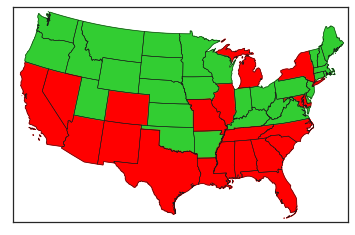

In [142]:
map.readshapefile('st99_d00', name='states', drawbounds=True)
ax = plt.gca()
for state in arrestsDF2.index.tolist():
    color = ''
    if arrestsDF2.loc[state, 'Risk'] == 'High':
        color = 'red'
    if arrestsDF2.loc[state, 'Risk'] == 'Low':
        color = 'limegreen'
    for i in [i for i, x in enumerate(state_names) if x == state]:
        seg = map.states[i]
        poly = Polygon(seg, facecolor = color, edgecolor = color)
        ax.add_patch(poly)
    
plt.show()

### k = 3

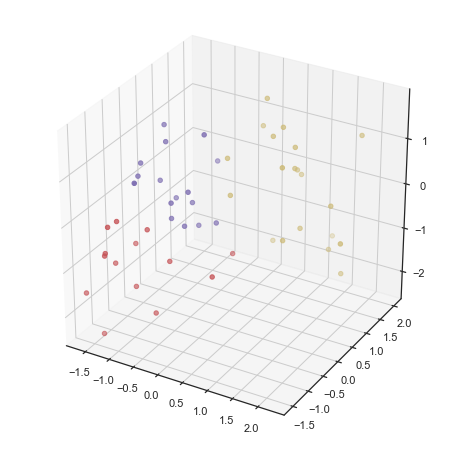

In [143]:
km3 = KMeans(init = 'random', n_clusters = 3, random_state = 333)
km3.fit(scaledDF)

# No graficamos los centros, pues estos están normalizados.
plot_clusters(scaledDF.values, km3.labels_)

In [144]:
arrestsDF3 = arrestsDF.assign( cluster = pd.Series(data = km3.labels_, index = arrestsDF.index))
arrestsDF3.head(10)

,Murder,Assault,UrbanPop,Rape,cluster
State,,,,,
Alabama,13.2,236,58,21.2,1
Alaska,10.0,263,48,44.5,1
Arizona,8.1,294,80,31.0,1
Arkansas,8.8,190,50,19.5,0
California,9.0,276,91,40.6,1
Colorado,7.9,204,78,38.7,1
Connecticut,3.3,110,77,11.1,2
Delaware,5.9,238,72,15.8,2
Florida,15.4,335,80,31.9,1


#### Por asesinato.

In [51]:
arrestsDF3.loc[: ,['Murder','cluster']].groupby(['cluster']).describe()

Murder                                                    
         count       mean       std  min   25%    50%    75%   max
cluster                                                           
0         14.0   3.971429  2.661529  0.8   2.2   2.65   5.35   9.7
1         20.0  12.165000  2.684904  7.9  10.3  12.15  13.50  17.4
2         16.0   5.656250  1.647207  3.2   4.3   5.95   6.90   8.5

#### Por asalto.

In [52]:
arrestsDF3.loc[: ,['Assault','cluster']].groupby(['cluster']).describe()

Assault                                                         
          count     mean        std    min     25%    50%     75%    max
cluster                                                                 
0          14.0   86.500  38.697545   45.0   56.25   82.0  107.25  190.0
1          20.0  255.250  44.116920  178.0  229.75  254.5  280.50  337.0
2          16.0  138.875  41.175842   46.0  114.50  147.0  159.00  238.0

#### Por violación.

In [53]:
arrestsDF3.loc[: ,['Rape','cluster']].groupby(['cluster']).describe()

Rape                                                      
        count      mean       std   min     25%    50%    75%   max
cluster                                                            
0        14.0  12.70000  3.692196   7.3   9.825  12.05  15.95  19.5
1        20.0  29.16500  8.386473  16.1  23.625  27.35  32.85  46.0
2        16.0  18.78125  5.236439   8.3  15.750  19.40  21.10  29.3

#### Por población urbana.

In [54]:
arrestsDF3.loc[: ,['UrbanPop','cluster']].groupby(['cluster']).describe()

UrbanPop                                                      
           count       mean        std   min    25%   50%    75%   max
cluster                                                               
0           14.0  51.928571   9.706970  32.0  46.25  52.5  56.75  66.0
1           20.0  68.400000  14.463748  44.0  58.75  70.0  80.00  91.0
2           16.0  73.875000   8.935883  60.0  66.75  72.5  80.75  89.0

#### Conclusiones.

Por los datos estadísticos, podemos clasificar los 3 clusters en niveles de criminalidad crecientes.

In [145]:
arrestsDF3['Risk'] = 'NaN'
arrestsDF3.loc[ arrestsDF3['cluster'] == 0, 'Risk'] = 'Low'
arrestsDF3.loc[ arrestsDF3['cluster'] == 2, 'Risk'] = 'Medium'
arrestsDF3.loc[ arrestsDF3['cluster'] == 1, 'Risk'] = 'High'
arrestsDF3.loc[:, ['Risk']].sort_values(by = ['Risk', 'State'])

,Risk
State,
Alabama,High
Alaska,High
Arizona,High
California,High
Colorado,High
Florida,High
Georgia,High
Illinois,High
Louisiana,High


#### Diagrama de dispersión.

In [146]:
arrestsDF3.head()

,Murder,Assault,UrbanPop,Rape,cluster,Risk
State,,,,,,
Alabama,13.2,236,58,21.2,1,High
Alaska,10.0,263,48,44.5,1,High
Arizona,8.1,294,80,31.0,1,High
Arkansas,8.8,190,50,19.5,0,Low
California,9.0,276,91,40.6,1,High


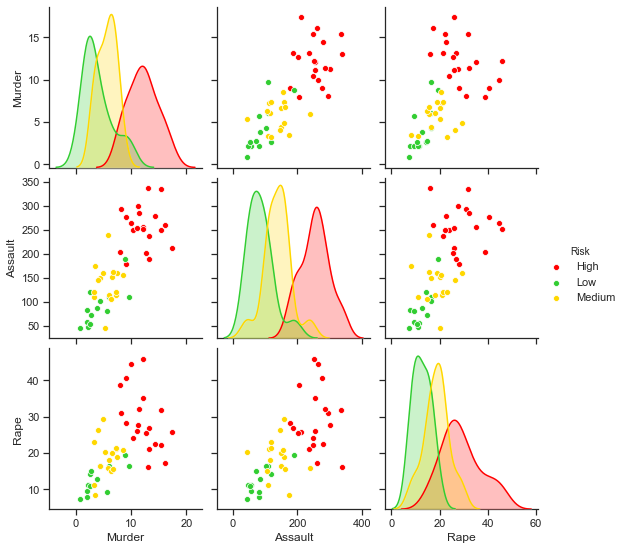

In [147]:
import seaborn as sns
sns.set(style = 'ticks')

sns.pairplot(
    arrestsDF3.iloc[:, [0,1,3,5]], 
    hue = 'Risk',
    palette = {'High': 'red', 'Medium': 'gold', 'Low': 'limegreen'})

#### Representación geográfica.

C:\Lenguajes\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


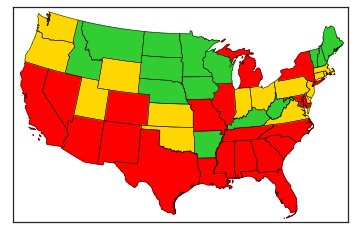

In [148]:
map.readshapefile('st99_d00', name='states', drawbounds=True)
ax = plt.gca()
for state in arrestsDF3.index.tolist():
    color = ''
    if arrestsDF3.loc[state, 'Risk'] == 'High':
        color = 'red'
    if arrestsDF3.loc[state, 'Risk'] == 'Medium':
        color = 'gold'
    if arrestsDF3.loc[state, 'Risk'] == 'Low':
        color = 'limegreen'
    for i in [i for i, x in enumerate(state_names) if x == state]:
        seg = map.states[i]
        poly = Polygon(seg, facecolor = color, edgecolor = color)
        ax.add_patch(poly)
    
plt.show()

## __Cuestión 4:__ Clustering Aglomerativo

Hallamos los valores más adecuados para la k, para el método jerárquico aglomerativo.

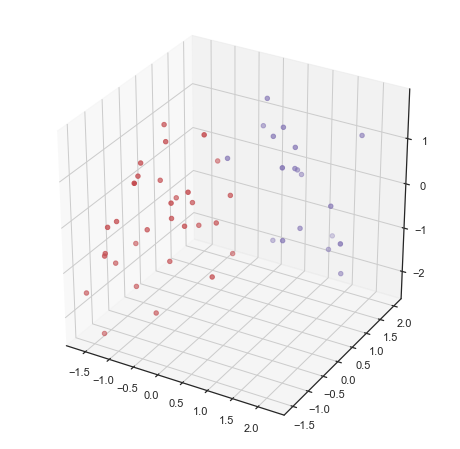

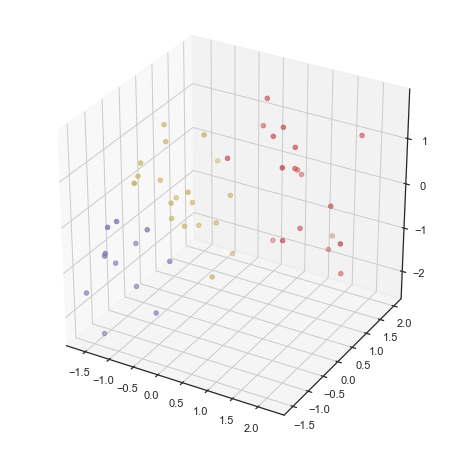

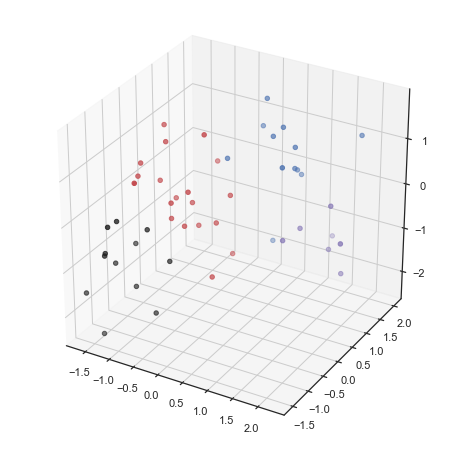

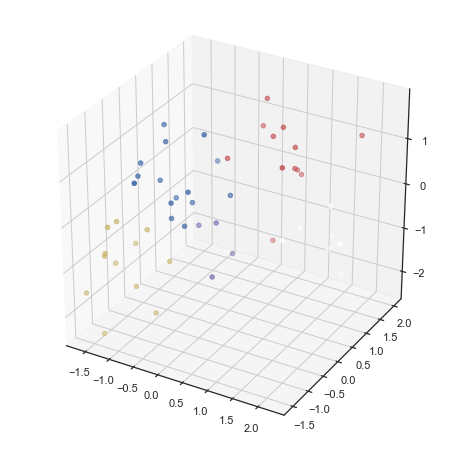

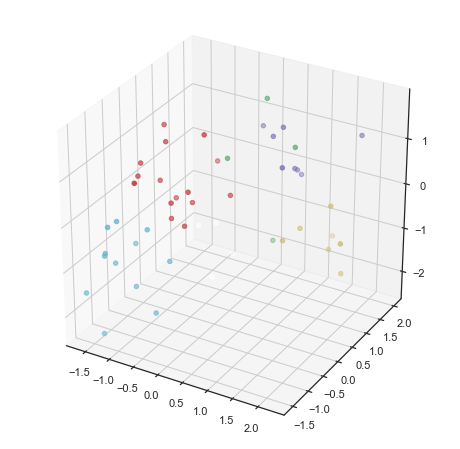

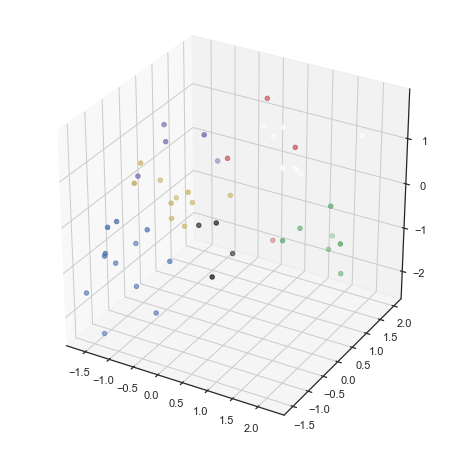

In [154]:
K_MAX = 8
davies_boulding = np.zeros(K_MAX-2)
for k in range(2, K_MAX): 
    ag = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean')
    ag.fit(scaledDF.values)
    plot_clusters(scaledDF.values, ag.labels_)
    
    davies_boulding[k-2] = davies_bouldin_score(scaledDF.values, ag.labels_)

Text(0.5, 1.0, 'Valor de Davies Boulding para diferentes k')

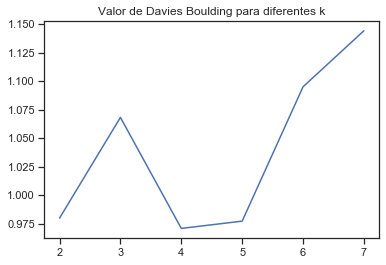

In [155]:
plt.plot(range(2, K_MAX), davies_boulding)
plt.title('Valor de Davies Boulding para diferentes k')

Obtenemos dos mínimos casi equivalentes para una división en 2 y 4 cluster, que analizamos a continuación.

### k = 2

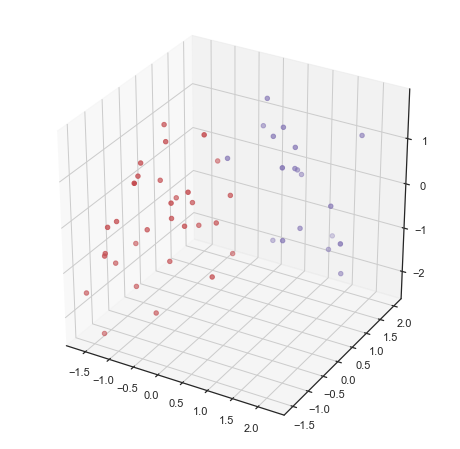

In [156]:
ag2 = AgglomerativeClustering(n_clusters = 2, linkage = 'ward', affinity = 'euclidean')
ag2.fit(scaledDF)
plot_clusters(scaledDF.values, ag2.labels_)

In [157]:
arrestsAG2 = arrestsDF.assign( cluster = pd.Series(data = ag2.labels_, index = arrestsDF.index))
arrestsAG2.head(10)

,Murder,Assault,UrbanPop,Rape,cluster
State,,,,,
Alabama,13.2,236,58,21.2,1
Alaska,10.0,263,48,44.5,1
Arizona,8.1,294,80,31.0,1
Arkansas,8.8,190,50,19.5,0
California,9.0,276,91,40.6,1
Colorado,7.9,204,78,38.7,1
Connecticut,3.3,110,77,11.1,0
Delaware,5.9,238,72,15.8,0
Florida,15.4,335,80,31.9,1


#### Por asesinato.

In [158]:
arrestsAG2.loc[: ,['Murder','cluster']].groupby(['cluster']).describe()

Murder                                                   
         count       mean       std  min    25%   50%   75%   max
cluster                                                          
0         31.0   5.003226  2.383902  0.8   2.95   4.9   6.7   9.7
1         19.0  12.331579  2.650168  7.9  10.75  12.2  13.8  17.4

#### Por asalto.

In [159]:
arrestsAG2.loc[: ,['Assault','cluster']].groupby(['cluster']).describe()

Assault                                                          
          count        mean        std    min    25%    50%    75%    max
cluster                                                                  
0          31.0  116.483871  48.059596   45.0   82.0  113.0  153.5  238.0
1          19.0  259.315789  41.297098  188.0  242.5  255.0  282.0  337.0

#### Por violación.

In [160]:
arrestsAG2.loc[: ,['Rape','cluster']].groupby(['cluster']).describe()

Rape                                                    
        count       mean       std   min    25%   50%   75%   max
cluster                                                          
0        31.0  16.338710  5.802395   7.3  11.25  16.3  20.1  29.3
1        19.0  29.215789  8.613121  16.1  23.25  26.9  33.6  46.0

#### Por población urbana.

In [161]:
arrestsAG2.loc[: ,['UrbanPop','cluster']].groupby(['cluster']).describe()

UrbanPop                                                    
           count       mean        std   min   25%   50%   75%   max
cluster                                                             
0           31.0  63.838710  14.210552  32.0  53.5  66.0  72.5  89.0
1           19.0  68.315789  14.855050  44.0  58.5  70.0  80.0  91.0

#### Conclusiones.

Volvemos a obtener 2 clusters, que resultan ser equivalentes a los del resultado de K-Means para k = 2.

In [162]:
arrestsAG2['Risk'] = 'NaN'
arrestsAG2.loc[ arrestsAG2['cluster'] == 0, 'Risk'] = 'Low'
arrestsAG2.loc[ arrestsAG2['cluster'] == 1, 'Risk'] = 'High'
arrestsAG2.loc[:, ['Risk']].sort_values(by = ['Risk', 'State'])

,Risk
State,
Alabama,High
Alaska,High
Arizona,High
California,High
Colorado,High
Florida,High
Georgia,High
Illinois,High
Louisiana,High


#### Diagrama de dispersión.

In [163]:
arrestsAG2.head()

,Murder,Assault,UrbanPop,Rape,cluster,Risk
State,,,,,,
Alabama,13.2,236,58,21.2,1,High
Alaska,10.0,263,48,44.5,1,High
Arizona,8.1,294,80,31.0,1,High
Arkansas,8.8,190,50,19.5,0,Low
California,9.0,276,91,40.6,1,High


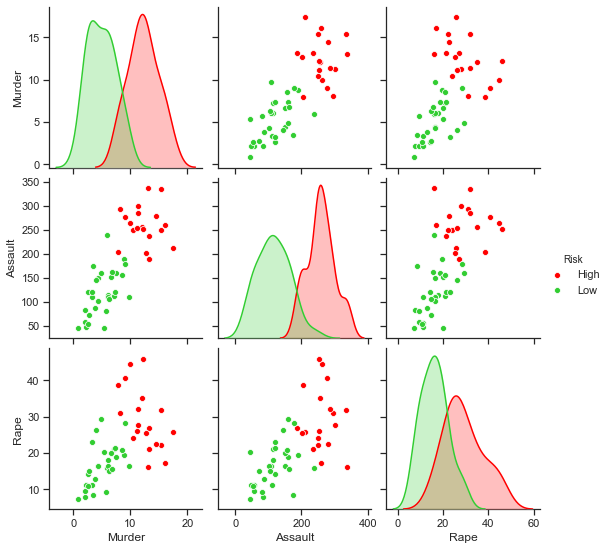

In [164]:
import seaborn as sns
sns.set(style = 'ticks')

sns.pairplot(
    arrestsAG2.iloc[:, [0,1,3,5]], 
    hue = 'Risk',
    palette = {'High': 'red', 'Low': 'limegreen'})


#### Representación geográfica.

C:\Lenguajes\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


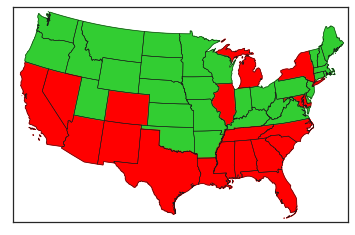

In [166]:
map.readshapefile('st99_d00', name='states', drawbounds=True)
ax = plt.gca()
for state in arrestsAG2.index.tolist():
    color = ''
    if arrestsAG2.loc[state, 'Risk'] == 'High':
        color = 'red'
    #if arrestsDF3.loc[state, 'Risk'] == 'Medium':
    #    color = 'gold'
    if arrestsAG2.loc[state, 'Risk'] == 'Low':
        color = 'limegreen'
    for i in [i for i, x in enumerate(state_names) if x == state]:
        seg = map.states[i]
        poly = Polygon(seg, facecolor = color, edgecolor = color)
        ax.add_patch(poly)
    
plt.show()

### k = 4

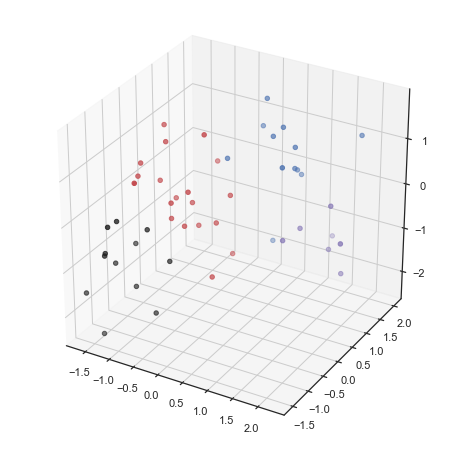

In [167]:
ag4 = AgglomerativeClustering(n_clusters = 4, linkage = 'ward', affinity = 'euclidean')
ag4.fit(scaledDF)
plot_clusters(scaledDF.values, ag4.labels_)

In [168]:
arrestsAG4 = arrestsDF.assign( cluster = pd.Series(data = ag4.labels_, index = arrestsDF.index))
arrestsAG4.head(10)

,Murder,Assault,UrbanPop,Rape,cluster
State,,,,,
Alabama,13.2,236,58,21.2,3
Alaska,10.0,263,48,44.5,1
Arizona,8.1,294,80,31.0,1
Arkansas,8.8,190,50,19.5,0
California,9.0,276,91,40.6,1
Colorado,7.9,204,78,38.7,1
Connecticut,3.3,110,77,11.1,0
Delaware,5.9,238,72,15.8,0
Florida,15.4,335,80,31.9,1


#### Por asesinato.

In [169]:
arrestsAG4.loc[: ,['Murder','cluster']].groupby(['cluster']).describe()

Murder                                                       
         count       mean       std   min     25%   50%     75%   max
cluster                                                              
0         19.0   6.210526  2.003856   3.2   4.650   6.3   7.350   9.7
1         12.0  10.966667  2.100361   7.9   9.750  11.2  12.125  15.4
2         12.0   3.091667  1.557071   0.8   2.175   2.6   3.925   6.0
3          7.0  14.671429  1.693826  13.0  13.200  14.4  15.750  17.4

#### Por asalto.

In [170]:
arrestsAG4.loc[: ,['Assault','cluster']].groupby(['cluster']).describe()

Assault                                                            
          count        mean        std    min     25%    50%     75%    max
cluster                                                                    
0          19.0  142.052632  41.012835   46.0  114.00  149.0  160.00  238.0
1          12.0  264.000000  38.069315  201.0  251.25  259.0  287.25  335.0
2          12.0   76.000000  25.092556   45.0   55.25   76.5   90.00  120.0
3           7.0  251.285714  48.376007  188.0  223.50  249.0  269.00  337.0

#### Por violación.

In [171]:
arrestsAG4.loc[: ,['Rape','cluster']].groupby(['cluster']).describe()

Rape                                                        
        count       mean       std   min     25%    50%     75%   max
cluster                                                              
0        19.0  19.184211  5.289430   8.3  16.050  19.50  21.200  29.3
1        12.0  33.608333  7.443051  24.0  27.375  32.00  39.175  46.0
2        12.0  11.833333  3.147967   7.3   9.450  11.25  14.375  16.5
3         7.0  21.685714  4.031306  16.1  19.150  22.20  24.150  26.9

#### Por población urbana.

In [172]:
arrestsAG4.loc[: ,['UrbanPop','cluster']].groupby(['cluster']).describe()

UrbanPop                                                      
           count       mean        std   min    25%   50%    75%   max
cluster                                                               
0           19.0  71.263158  10.882412  50.0  65.50  72.0  78.50  89.0
1           12.0  76.500000  11.090537  48.0  73.00  80.0  81.50  91.0
2           12.0  52.083333  10.535294  32.0  44.75  53.5  58.25  66.0
3            7.0  54.285714   8.538429  44.0  46.50  58.0  59.50  66.0

#### Conclusiones

En este caso, obtenemos 4 grupos, que no podemos ordenar de forma creciente por criminalidad (al menos no en su totalidad). Claramente se distinguen dos grupos con niveles de criminalidad más bajos que los otros dos, que parecen mantener un nivel similar de criminalidad. No obstante, observando los diagramas de dispersión, observamos que en uno de ellos, el número de asesinatos es mayor respecto al otro, mientras que ocurre en el otro, las violaciones son mayores con respecto al resto.

In [179]:
arrestsAG4['Risk'] = 'NaN'
arrestsAG4.loc[ arrestsAG4['cluster'] == 2, 'Risk'] = 'Low'
arrestsAG4.loc[ arrestsAG4['cluster'] == 0, 'Risk'] = 'Moderate'
arrestsAG4.loc[ arrestsAG4['cluster'] == 1, 'Risk'] = 'High (Rape)'
arrestsAG4.loc[ arrestsAG4['cluster'] == 3, 'Risk'] = 'High (Murder)'
arrestsAG4.loc[:, ['Risk']].sort_values(by = ['Risk', 'State'])

,Risk
State,
Alabama,High (Murder)
Georgia,High (Murder)
Louisiana,High (Murder)
Mississippi,High (Murder)
North Carolina,High (Murder)
South Carolina,High (Murder)
Tennessee,High (Murder)
Alaska,High (Rape)
Arizona,High (Rape)


#### Diagrama de dispersión.

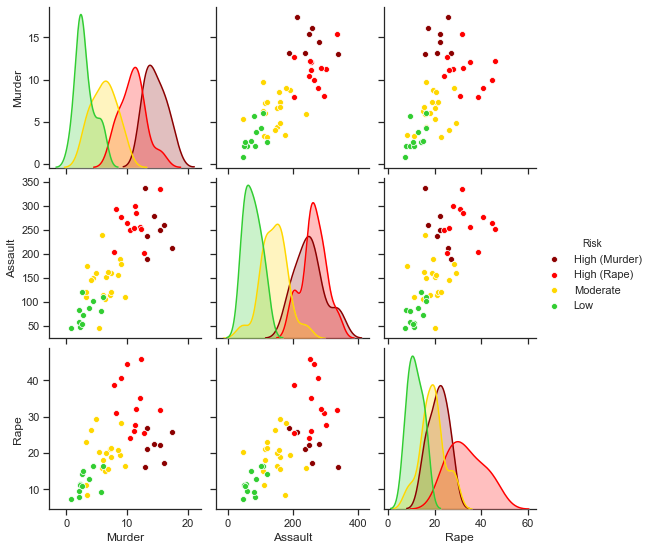

In [185]:
import seaborn as sns
sns.set(style = 'ticks')

sns.pairplot(
    arrestsAG4.loc[:, ['Murder', 'Assault', 'Rape', 'Risk']], 
    hue = 'Risk',
    palette = {'High (Rape)': 'red', 'High (Murder)': 'darkred', 'Moderate': 'gold', 'Low': 'limegreen'})

#### Representación geográfica.

C:\Lenguajes\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


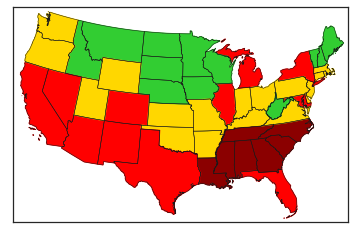

In [184]:
map.readshapefile('st99_d00', name='states', drawbounds=True)
ax = plt.gca()
for state in arrestsAG4.index.tolist():
    color = ''
    if arrestsAG4.loc[state, 'Risk'] == 'High (Rape)':
        color = 'red'
    if arrestsAG4.loc[state, 'Risk'] == 'High (Murder)':
        color = 'darkred'
    if arrestsAG4.loc[state, 'Risk'] == 'Moderate':
        color = 'gold'
    if arrestsAG4.loc[state, 'Risk'] == 'Low':
        color = 'limegreen'
    for i in [i for i, x in enumerate(state_names) if x == state]:
        seg = map.states[i]
        poly = Polygon(seg, facecolor = color, edgecolor = color)
        ax.add_patch(poly)
    
plt.show()